In [1]:
using Images, FileIO, Plots


(process:30940): GLib-GIO-WARNING **: 10:54:29.581: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2312.33.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:30940): GLib-GIO-WARNING **: 10:54:29.621: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.9.1.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


In [99]:
function load_image(path)
    img = load(path)
    ny, nx = size(img)
    arr = ones(ny,nx)
    for i = 1:nx
        for j = 1:ny
            if img[j,i].r == img[j,i].g == img[j,i].b && img[j,i].r == 1.0N0f8
                arr[j,i] = 0
            end
        end
    end
    return arr
end

function get_boundary_coordinates(reference)
    ny, nx = size(reference)
    left_boundary_coordinates = []
    right_boundary_coordinates = []
    for iy = 1:ny
        for ix = 1:nx
            current_pixel = reference[iy,ix]
            if ix > 1
                previous_pixel = reference[iy,ix-1]
                    if current_pixel == 1 && previous_pixel == 0
                        #println("left edge at (",ix, ",", iy, ")")
                        push!(left_boundary_coordinates,[ix,iy])
                    end
            end
            if ix < nx
                next_pixel = reference[iy,ix+1]
                if current_pixel == 1 && next_pixel == 0
                        #println("right edge at (",ix, ",", iy, ")")
                        push!(right_boundary_coordinates,[ix,iy])
                end
            end


        end
    end
    return [left_boundary_coordinates, right_boundary_coordinates]
end

function get_geometry_data(left_boundary_coordinates, right_boundary_coordinates)
    center_points = zeros(length(left_boundary_coordinates),2)
    geometry_length = zeros(length(left_boundary_coordinates))
    for i = 1:length(left_boundary_coordinates)
        Lx, y = left_boundary_coordinates[i]
        Rx, _ = right_boundary_coordinates[i]
        center_points[i,:] = [(Rx+Lx)/2, y]
        geometry_length[i] = sqrt((Rx - Lx)^2)
    end
    return [center_points, geometry_length]
end

function display_results(reference, left_boundary_coordinates, right_boundary_coordinates; dim = (500,500))
    f = heatmap(reference, title = "Geometry",wsize = dim, cbar = false, dpi = 300)
    anim=@animate for  i = 1:size(left_boundary_coordinates)[1]
        f = plot!([left_boundary_coordinates[i][1], right_boundary_coordinates[i][1]],[left_boundary_coordinates[i][2], right_boundary_coordinates[i][2]], 
            legend = false,
            xlims = (1,nx), 
            ylims = (1,ny), 
            lw = 4,
            linealpha = 0.5,
            dpi = 300)

        f = scatter!([center_points[i,1]], [center_points[i,2]], mc = :black, ms = 2, dpi = 300)
        f = scatter!([center_points[i,1] - geometry_length[i]/2], [center_points[i,2]], mc = :red, ms = 2, dpi = 300)
        f = scatter!([center_points[i,1] + geometry_length[i]/2], [center_points[i,2]], mc = :red, ms = 2, dpi = 300)
    end
    return [f, anim]
end

display_results (generic function with 1 method)

In [45]:

img = load(path)
img[1,1].r

1.0N0f8

In [69]:
path = raw"test.png"

reference = load_image(path)
ny, nx = size(reference)

(10, 10)

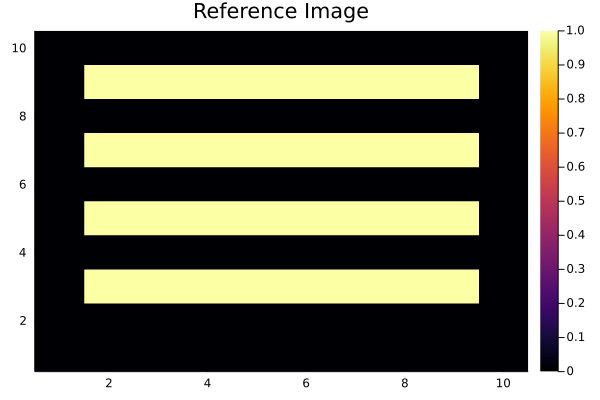

In [70]:
x = 1:nx
z = 1:ny
heatmap(reference, title = "Reference Image")

2-element Vector{Vector{Any}}:
 [[2, 3], [2, 5], [2, 7], [2, 9]]
 [[9, 3], [9, 5], [9, 7], [9, 9]]

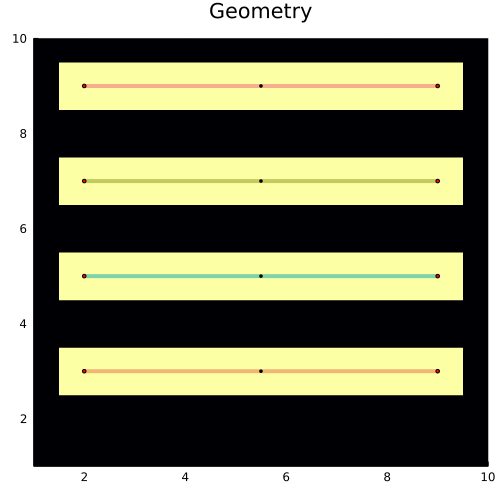

In [100]:

left_boundary_coordinates, right_boundary_coordinates = get_boundary_coordinates(reference)
center_points, geometry_length = get_geometry_data(left_boundary_coordinates, right_boundary_coordinates)
f, _ = display_results(reference, left_boundary_coordinates, right_boundary_coordinates, dim = (500,500))
f

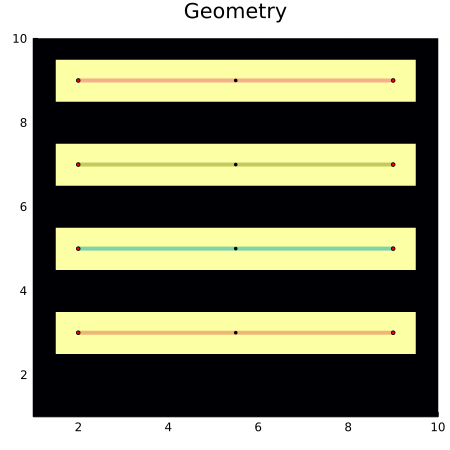

In [83]:
f = heatmap(reference, title = "Geometry",wsize = (450,450), cbar = false)
anim=@animate for  i = 1:size(left_boundary_coordinates)[1]

    f = plot!([left_boundary_coordinates[i][1], right_boundary_coordinates[i][1]],[left_boundary_coordinates[i][2], right_boundary_coordinates[i][2]], 
        legend = false,
        xlims = (1,nx), 
        ylims = (1,ny), 
        lw = 4,
        linealpha = 0.5)

    f = scatter!([center_points[i,1]], [center_points[i,2]], mc = :black, ms = 2)
    f = scatter!([center_points[i,1] - geometry_length[i]/2], [center_points[i,2]], mc = :red, ms = 2)
    f = scatter!([center_points[i,1] + geometry_length[i]/2], [center_points[i,2]], mc = :red, ms = 2)

end
f
#gif(anim)

In [89]:

function write_geometry(filename;xz_coordinate,y_coordinate, block_length,thickness,material, append = false, final = false)
    if append == false
        open("geometry.json", "w") do file
            str = string("[{\n
                         \"shape\": \"Rectangle\",
                         \"radius\": 1e-9,
                         \"length\": 1e-9,
                         \"width\": ",block_length,"e-9,
                         \"thickness\": ",thickness,"e-9,
                         \"material\": \"",material,"\",
                         \"position\": [",xz_coordinate[1],",",y_coordinate,",",xz_coordinate[2],"] \n}")
            write(file, str)
            write(file, ",\n")
        end
    elseif append == true && final == false
                open("geometry.json", "a") do file
            str = string("{\n
                         \"shape\": \"Rectangle\",
                         \"radius\": 1e-9,
                         \"length\": 1e-9,
                         \"width\": ",block_length,"e-9,
                         \"thickness\": ",thickness,"e-9,
                         \"material\": \"",material,"\",
                         \"position\": [",xz_coordinate[1],",",y_coordinate,",",xz_coordinate[2],"] \n}")
            write(file, str)
            write(file, ",\n")
        end
    elseif append == true && final == true
                open("geometry.json", "a") do file
            str = string("{\n
                         \"shape\": \"Rectangle\",
                         \"radius\": 1e-9,
                         \"length\": 1e-9,
                         \"width\": ",block_length,"e-9,
                         \"thickness\": ",thickness,"e-9,
                         \"material\": \"",material,"\",
                         \"position\": [",xz_coordinate[1],",",y_coordinate,",",xz_coordinate[2],"] \n}")
            write(file, str)
            write(file, "\n]")
        end
    end
end





write_geometry (generic function with 3 methods)

In [90]:
materials =[]
push!(materials,
    Dict(
    "material" => "gold",
    "thickness" => 30,
    "y-coordinate" => 165,
    "xz-coordinates" => center_points,
    "block-lengths"=> geometry_length
    ) )
push!(materials,
    Dict(
    "material" => "chromium",
    "thickness" => 3,
    "y-coordinate" => 151.5,
    "xz-coordinates" => center_points,
    "block-lengths"=> geometry_length
    ) )
function generate_geometry_file(materials)
    write_geometry(
        "geometry.json",
        xz_coordinate = materials[1]["xz-coordinates"][1,:],
        y_coordinate = materials[1]["y-coordinate"],
        thickness = materials[1]["thickness"],
        material = materials[1]["material"],
        block_length = materials[1]["block-lengths"][1]
        )
    for k = 2:length(materials)
        write_geometry(
            "geometry.json",
            xz_coordinate = materials[k]["xz-coordinates"][1,:],
            y_coordinate = materials[k]["y-coordinate"],
            thickness = materials[k]["thickness"],
            material = materials[k]["material"],
            block_length = materials[k]["block-lengths"][1],
            append = true
            )
    end

    for i = 1:length(materials[1]["block-lengths"])-1
        for k = 1:length(materials)
            write_geometry(
                "geometry.json",
                xz_coordinate = materials[k]["xz-coordinates"][i,:],
                y_coordinate = materials[k]["y-coordinate"],
                thickness = materials[k]["thickness"],
                material = materials[k]["material"],
                block_length = materials[k]["block-lengths"][i],
                append = true
                )
        end
    end
    for k = 2:length(materials)
        write_geometry(
            "geometry.json",
            xz_coordinate = materials[k]["xz-coordinates"][end,:],
            y_coordinate = materials[k]["y-coordinate"],
            thickness = materials[k]["thickness"],
            material = materials[k]["material"],
            block_length = materials[k]["block-lengths"][end],
            append = true
            )
    end
    write_geometry(
            "geometry.json",
            xz_coordinate = materials[1]["xz-coordinates"][end,:],
            y_coordinate = materials[1]["y-coordinate"],
            thickness = materials[1]["thickness"],
            material = materials[1]["material"],
            block_length = materials[1]["block-lengths"][end],
            append = true,
            final = true
            )
end

generate_geometry_file (generic function with 1 method)

In [93]:
generate_geometry_file(materials)

2